# QuantEM Demo: Pauli Check Sandwiching (PCS)
This notebook demonstrates the QuantEM compiler's end-to-end workflow for applying PCS to a quantum circuit. Specifically, we show the case where PCS checks are placed on the largest Clifford block of the circuit.

**Key Steps:**
1. **Circuit Analysis** - Identify the largest Clifford block suitable for PCS protection
2. **QED Integration** - Automatically insert Pauli checks and ancilla qubits  
3. **Hardware Mapping** - Map the protected circuit to quantum hardware using VF2
4. **Performance Evaluation** - Compare fidelity improvements and postselection overhead

In [1]:
import numpy as np

from quantem.utils import (
    convert_to_PCS_circ_largest_clifford,
    get_VF2_layouts,
)
from quantem.pauli_checks import postselect_counts

### **Step 0:** Generate circuit

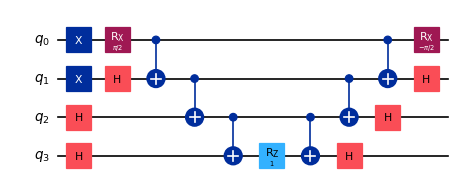

In [2]:
from qiskit.circuit import QuantumCircuit


def hydrogen_trial_circuit(num_qubits):
    qc = QuantumCircuit(num_qubits)
    # prepare the Hartree-Fock state
    qc.x(0)
    qc.x(1)

    qc.rx(np.pi / 2, 0)
    qc.h(1)
    qc.h(2)
    qc.h(3)

    # qc.barrier()
    qc.cx(0, 1)
    qc.cx(1, 2)
    qc.cx(2, 3)
    # qc.barrier()

    qc.rz(1.0, 3)

    qc.cx(2, 3)
    qc.cx(1, 2)
    qc.cx(0, 1)

    qc.rx(-np.pi / 2, 0)
    qc.h(1)
    qc.h(2)
    qc.h(3)

    return qc

circ = hydrogen_trial_circuit(4)
circ.draw("mpl", scale=0.6)

### **Step 1:** Find largest Clifford block and apply checks around it

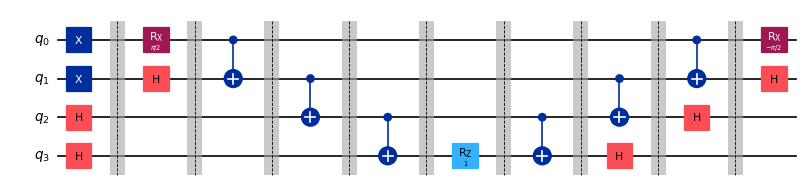

In [3]:
from qiskit_addon_utils.slicing import combine_slices, slice_by_depth

slices = slice_by_depth(circ, 1)
combined_slices = combine_slices(slices, include_barriers=True)
combined_slices.draw("mpl", scale=0.6)

### **Step 2:** Integrate QED strategy

Largest Clifford block is from slice 6 to 8.
Found check 1: +1XXXX, +1IIIX
Found check 2: +1IIIZ, +1IIIZ
Required number of checks found.
p1_list =  [['+1XXXX', '+1IIIX'], ['+1IIIZ', '+1IIIZ']]
['+1', '+1']


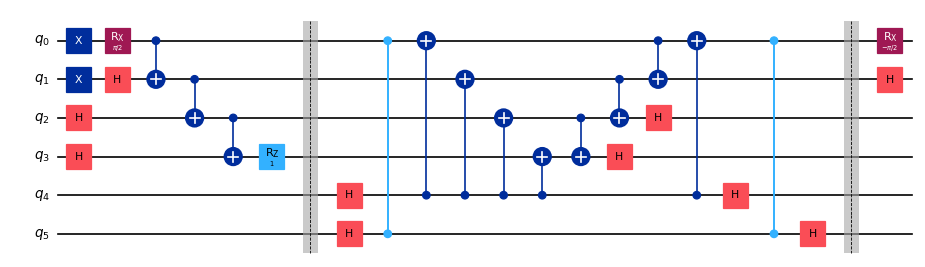

In [4]:
num_qubits = 4
num_checks = 2

sign_list, pcs_circ = convert_to_PCS_circ_largest_clifford(circ, num_qubits, num_checks)
print(sign_list)
pcs_circ.draw("mpl", scale=0.6, fold=-1)

### What just happened?

The compiler identified that slices 6-8 of the original circuit contain only Clifford gates, making them ideal for PCS protection. The protected circuit is now ready for hardware execution with built-in error detection.

### **Step 3:** Map to backend using VF2 algorithm 

### Select backend

In [5]:
from qiskit_ibm_runtime.fake_provider import FakeSherbrooke

fake_backend = FakeSherbrooke()
fake_coupling_map = fake_backend.configuration().coupling_map

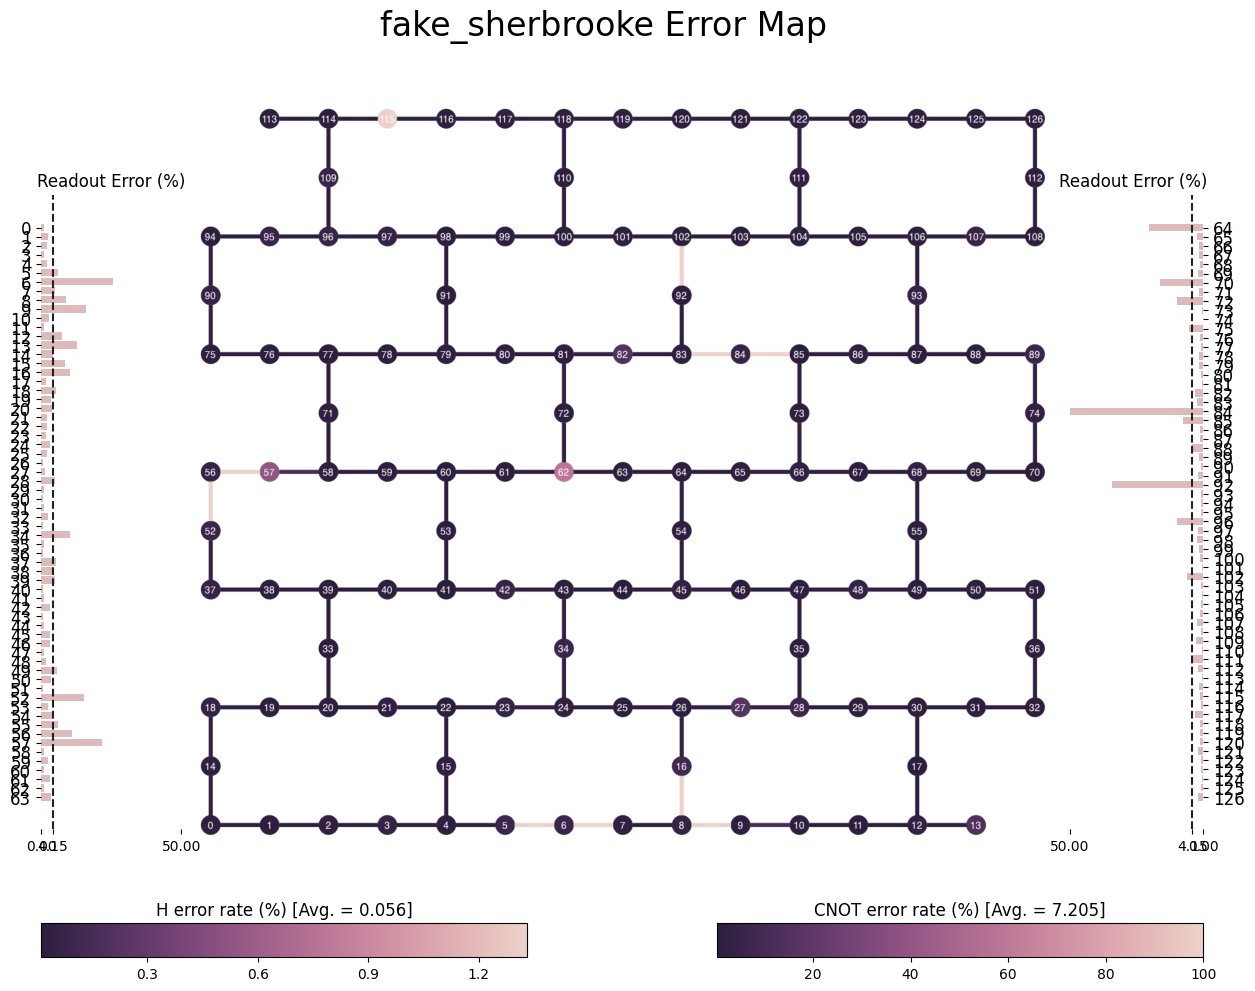

In [6]:
from qiskit.visualization import plot_error_map

plot_error_map(fake_backend)

### Map original circuit and pcs protected circuit to backend using VF2 mapping algorithm

In [7]:
VF2_mapping_ranges, small_qc = get_VF2_layouts(circ, fake_backend)
print(len(VF2_mapping_ranges))
print(VF2_mapping_ranges)

mapping_range = VF2_mapping_ranges[0]
print(mapping_range)

14
[[9, 8, 16, 26], [40, 41, 42, 43], [3, 4, 5, 6], [44, 45, 54, 64], [48, 49, 55, 68], [62, 72, 81, 80], [96, 109, 114, 113], [13, 12, 11, 10], [20, 19, 18, 14], [51, 36, 32, 31], [38, 37, 52, 56], [104, 105, 106, 93], [124, 125, 126, 112], [111, 122, 121, 120]]
[9, 8, 16, 26]


In [8]:
pcs_VF2_mapping_ranges, pcs_small_qc = get_VF2_layouts(pcs_circ, fake_backend)
print(len(pcs_VF2_mapping_ranges))
print(pcs_VF2_mapping_ranges)

pcs_mapping_range = pcs_VF2_mapping_ranges[0]
print(pcs_mapping_range)

3
[[26, 25, 22, 23, 24, 34], [41, 53, 58, 59, 60, 61], [114, 109, 94, 95, 96, 97]]
[26, 25, 22, 23, 24, 34]


### **Step 4:** Performance evaluation

### Execute on noisy simulator

In [9]:
import qiskit_aer.noise as noise
from qiskit_aer.primitives import SamplerV2 as sampler

basis_gates = fake_backend.configuration().basis_gates
noise_model = noise.NoiseModel.from_backend(fake_backend)

noisy_sampler = sampler(options={"backend_options": {"noise_model": noise_model}})
ideal_sampler = sampler()

In [10]:
from qiskit import transpile

circ.measure_all()
pcs_circ.measure_all()

pcs_circ_transpiled = transpile(
    pcs_circ,
    basis_gates=basis_gates,
    initial_layout=pcs_mapping_range,
    optimization_level=1,
)
circ_transpiled = transpile(
    circ, basis_gates=basis_gates, initial_layout=mapping_range, optimization_level=1
)

noisy_job_result = noisy_sampler.run(
    [pcs_circ_transpiled, circ_transpiled], shots=10000
).result()

pcs_circ_counts = noisy_job_result[0].data.meas.get_counts()
noisy_circ_counts = noisy_job_result[1].data.meas.get_counts()

ideal_job_result = ideal_sampler.run([circ], shots=10000).result()
ideal_circ_counts = ideal_job_result[0].data.meas.get_counts()
postselected_counts = postselect_counts(pcs_circ_counts, sign_list, num_ancillas=2)

print(pcs_circ_counts)
print(postselected_counts)

{'001100': 1783, '000011': 6121, '100011': 737, '000111': 142, '101100': 218, '010011': 223, '001011': 121, '000001': 139, '100010': 16, '011100': 92, '111100': 13, '000000': 11, '010010': 14, '110011': 33, '100001': 22, '000101': 5, '001101': 25, '000010': 83, '001110': 34, '000100': 41, '010001': 5, '100111': 18, '010000': 7, '001010': 3, '011011': 5, '011101': 5, '101011': 11, '001000': 30, '100110': 2, '100101': 2, '101110': 5, '110001': 2, '101101': 2, '001001': 1, '101010': 1, '101000': 2, '111101': 2, '100100': 4, '110010': 2, '000110': 1, '110000': 2, '100000': 3, '010111': 2, '110111': 1, '011110': 2, '001111': 3, '010100': 1, '011010': 1, '110100': 1, '110110': 1}
{'1100': 1783, '0011': 6121, '0111': 142, '1011': 121, '0001': 139, '0000': 11, '0101': 5, '1101': 25, '0010': 83, '1110': 34, '0100': 41, '1010': 3, '1000': 30, '1001': 1, '0110': 1, '1111': 3}


### Gather results

In [11]:
from qiskit.quantum_info import hellinger_fidelity

raw_fidelity = hellinger_fidelity(ideal_circ_counts, noisy_circ_counts)
mitigated_fidelity = hellinger_fidelity(ideal_circ_counts, postselected_counts)
postselection_rate = sum(postselected_counts.values()) / sum(pcs_circ_counts.values())

print(f"raw fidelity: {raw_fidelity}")
print(f"mitigated fidelity: {mitigated_fidelity}")
print(f"postselection rate: {postselection_rate}")

raw fidelity: 0.6831857217744457
mitigated fidelity: 0.9251882772489268
postselection rate: 0.8543


### interpret results

In [12]:
improvement = (mitigated_fidelity - raw_fidelity) / raw_fidelity * 100
overhead = (1 - postselection_rate) * 100

print("🎯 QED Performance Summary")
print("=" * 30)
print(f"Raw fidelity:        {raw_fidelity:.3f}")
print(f"QED fidelity:        {mitigated_fidelity:.3f}")
print(f"Relative improvement: {improvement:+.1f}%")
print(f"Overhead (discarded): {overhead:.1f}% of runs")
print()

if improvement > 5:
    print("✅ QED provides significant improvement")
elif postselection_rate < 0.5:
    print("⚠️  High overhead - consider reducing num_checks")
else:
    print("📊 Modest improvement")

🎯 QED Performance Summary
Raw fidelity:        0.683
QED fidelity:        0.925
Relative improvement: +35.4%
Overhead (discarded): 14.6% of runs

✅ QED provides significant improvement
